In [3]:
import numpy as np
import pandas as pd

# Data preprocessing steps

In [4]:
df_train = pd.read_table('/home/sibi/acad/mach_learn_with_networks/assignment/2_lm_opt/bclass/bclass/bclass-train',delimiter='\t',header=None)
df_test = pd.read_table('/home/sibi/acad/mach_learn_with_networks/assignment/2_lm_opt/bclass/bclass/bclass-test',delimiter='\t',header=None)


In [5]:
#Converting -1 to 0
df_train.head()
df_train.loc[df_train[0] == -1,0] = 0
df_test.loc[df_test[0] == -1,0] = 0
df_train = df_train.drop(2, 1) #CAREFUL
df_test = df_test.drop(2,1) #CAREFUL LABEL NAMES


In [6]:
#Splitting as features and labels
X_train = df_train.ix[:,1:]
y_train = df_train[0]
X_test = df_test.loc[:,1:]
y_test = df_test.loc[:,0]

# Locally weighted logistic regression

## Gradient Descent Function

The locally weighted logistic regression problem is to maximize
$$ l(\theta) = \sum_{i=1}^{N} w^i \{y^ilog\:f_\beta (x^i) + (1-y^i)\:log(1 - log\:f_\beta(x^i)]\} - \lambda\beta^T\beta$$

We first solve for the gradient and hessian using this function l. We can then conver this as an iterative procedure using the Newton-Raphson method.

The gradient is given by  

$\quad \nabla_\theta\:l(\theta) = X^Tz - \lambda\theta$

where z is the expresion 

$\quad z_i = w^i \:(y^i - h_\theta(x^i)\:)$

and the Hessian is given by 

$\quad H = X^TDX - \lambda I$

Where D is the diagonal matrix

$\quad D_{ii} = -w^i h_\theta(x^i)(1-h_\theta(x^i))$

We now use these formulas to 
1. compute w i ’s for each development/test sample using the weight expression 
$w^i = exp(-\frac{||x - x^i||}{2\tau^2})$
2. maximize l(β) to learn β, 
3. predict y based on f β (x) (y = 1 when f β (x) ≥ 0.5),


In [104]:
lambda_value = 0.001

def sigmoid(z): 
    return 1 / (1 + np.e**(-z)) 

def hypothesis(theta, x):
    return sigmoid(np.dot(x, theta))

def gaussian(point1, point2, tau):
        return np.exp(- (np.linalg.norm(a-b)**2) / (2 * tau**2))

def weights(data, new_point, tau):
    assert (new_point.shape[0] == 1) #new point should be 1xn, where n is the number of features
    new_point_repeat = np.repeat(new_point, data.shape[0], axis = 0) 
    norm_squared = np.linalg.norm(data - new_point_repeat, axis = 1) ** 2
    weights = np.exp(-norm_squared / (2 * tau ** 2))
    return weights.reshape(len(weights), 1)
    
def lw_logreg(x_train, y_train, x, tau):
    x_train_aug = pd.concat([pd.Series(np.ones(len(x_train.index))), x_train], axis = 1)
    x_aug = np.concatenate([np.asarray([[1]]), x], axis = 1)
    
    theta_length = x_train_aug.shape[1] 
    theta = np.zeros([theta_length, 1])
    gradient = np.ones([33,1])

    dist = 1
    i = 0
    while dist > 0.0001 and i < 100:
        weights = getWeights(x_train_aug, x_aug, tau)
#         print hypothesis(theta,x_train_aug).shape
#         print weights.shape
#         print y_train.shape
        y_train = y_train.reshape(200,1)
        z = weights * (y_train - hypothesis(theta, x_train_aug))
        gradient = np.dot(x_train_aug.transpose(), z) -  lambda_value * theta

        diags = -weights * hypothesis(theta, x_aug) * (1 - hypothesis(theta, x_aug))
        D = np.diag(diags[:, 0])
        H = np.dot(np.dot(x_train_aug.transpose(), D), x_train_aug) - lambda_value * np.eye(x_train_aug.shape[1]) #Hessian

        theta_new = theta - np.dot(np.linalg.inv(H), gradient)

        dist = np.linalg.norm(theta_new - theta)
        theta = theta_new
        i +=1

    return theta



In [91]:
from sklearn import metrics

In [98]:
pred = []
train_accs = []
taus = [0.01, 0.05, 0.1, 1.0, 5.0]
for tau in taus:
    pred = []
    for i in xrange(200):
        x = X_train.iloc[[i]]
        final_theta = lw_logreg(X_train, y_train, x, tau)
        x_aug = np.concatenate([np.asarray([[1]]), x], axis = 1)

        if hypothesis(final_theta,x_aug) > 0.5:
            pred.append(1)
        else:
            pred.append(0)
       
    train_acc = metrics.accuracy_score(y_train,pred)
    print train_acc
    train_accs.append(train_acc)

1.0
1.0
1.0
0.665
0.665


In [101]:
pred = []
test_accs = []
taus = [0.01, 0.05, 0.1, 1.0, 5.0]
for tau in taus:
    pred = []
    for i in xrange(X_test.shape[0]):
        x = X_test.iloc[[i]]
        final_theta = lw_logreg(X_train, y_train, x, tau)
        x_aug = np.concatenate([np.asarray([[1]]), x], axis = 1)

        if hypothesis(final_theta,x_aug) > 0.5:
            pred.append(1)
        else:
            pred.append(0)
       
    test_acc = metrics.accuracy_score(y_test,pred)
    print test_acc
    test_accs.append(test_acc)

0.328947368421
0.552631578947
0.815789473684
0.565789473684
0.723684210526


# Plotting Error Rates

In [116]:
import matplotlib.pyplot as plt
%matplotlib inline

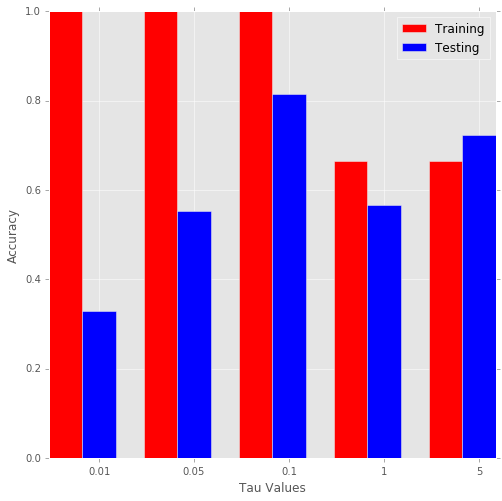

In [189]:
fig = plt.figure(figsize=(8, 8))
plt.style.use('ggplot')

width = 0.35
ind = np.arange(5)

ax1 = fig.add_subplot(1,1,1)
rects1 = ax1.bar(ind, train_accs, width, color='r',align='center',label='Training')
# ax1.hist(taus,train_accs,label="Training Accuracy",)
# ax1.bar( test_accs,label="Training Accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Tau Values")
ax1.set_xticks(ind+width)
ax1.set_xticklabels(('0.01', '0.05', '0.1', '1', '5'))

rects2 = ax1.bar(ind+width, test_accs, width, color='b',align ='center',label='Testing')
# ax1.hist(taus,train_accs,label="Training Accuracy",)
# ax1.bar( test_accs,label="Training Accuracy")
# ax1.set_ylabel("Accuracy")
# ax1.set_xlabel("Tau")
# ax2.set_xticklabels(('0','0.01', '0.05', '0.1', '1', '5'))
ax1.legend()
plt.show()

In [ ]:
Interpretatuo